Files already downloaded and verified
Using device: cpu
Accuracy for class: plane is 80.6 %
Accuracy for class: car   is 90.4 %
Accuracy for class: bird  is 73.2 %
Accuracy for class: cat   is 79.4 %
Accuracy for class: deer  is 79.7 %
Accuracy for class: dog   is 55.4 %
Accuracy for class: frog  is 80.4 %
Accuracy for class: horse is 78.3 %
Accuracy for class: ship  is 87.8 %
Accuracy for class: truck is 89.7 %
Accuracy of the network on the 10000 test images: 79.49%


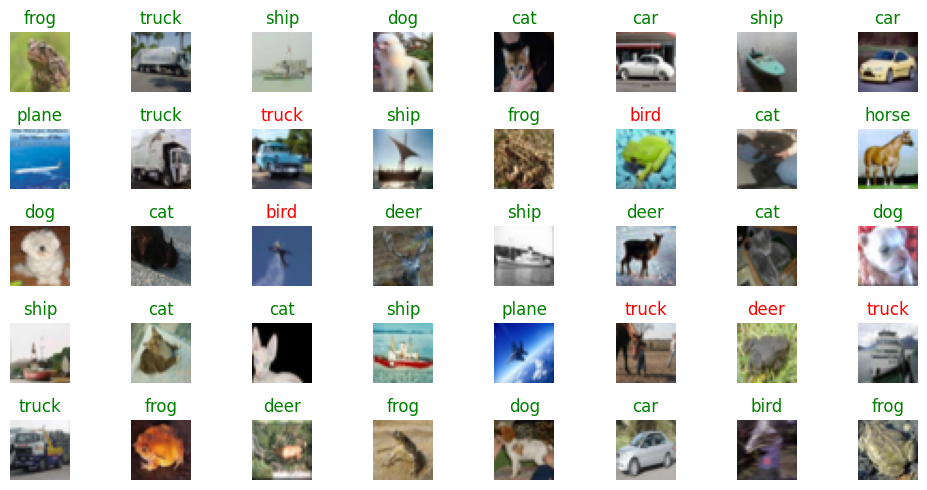

In [3]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from baseline import CIFAR10Model
import numpy as np

torch.manual_seed(42)

mean=[0.5, 0.5, 0.5]
std=mean

# 定义数据转换，包括使用计算的均值和标准差进行归一化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 加载修改后的标签
modified_labels = np.load('./modified_labels.npy')

# 创建DataLoader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

#Evaluation
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

model = CIFAR10Model().to(device)
model.load_state_dict(torch.load("finalmodel.pth"))
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = to_device(images, device), to_device(labels, device)           
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# 打印每个类别的准确率
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    accuracy = test_correct / test_total

print(f'Accuracy of the network on the 10000 test images: {100*accuracy:.2f}%')

# 选择要显示的图片数量
num_images = 40
# 创建图形和子图
fig, axs = plt.subplots(5, 8, figsize=(10, 5))
axs = axs.ravel()

for i in range(num_images):
    idx = torch.randint(len(test_dataset), size=(1,)).item()
    image, label = test_dataset[idx]
    # 使用训练好的模型进行预测
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0)
        image = image.to(device)
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        predicted_label = predicted.item()
    # 反归一化
    image = image / 2 + 0.5  # unnormalize
    npimg = image.cpu().numpy()[0]
    # 显示图片，并根据预测结果设置标签颜色
    axs[i].imshow(np.transpose(npimg, (1, 2, 0)))
    axs[i].set_title(classes[predicted_label], color='red' if label != predicted_label else 'green')
    axs[i].axis('off')
plt.tight_layout()
plt.show()